<a href="https://colab.research.google.com/github/PuchToTalk/LLM/blob/Llama/Ludwig_Llama7b_on_GPT_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Goal: Use LLMs trained on GPT-4** 💻





Install Ludwig from the latest release

In [1]:
!pip uninstall -y tensorflow --quiet
!pip install ludwig
!pip install ludwig[llm]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 116.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 13.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 12.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=4602d19f83c01891ef4fda5e08cbd42bba792c9781677e907ed518f9b0c4bb12
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


Install Ludwig from Ludwig master

In [2]:
# !pip uninstall -y tensorflow --quiet
# !pip install git+https://github.com/ludwig-ai/ludwig.git@master --quiet
# !pip install "git+https://github.com/ludwig-ai/ludwig.git@master#egg=ludwig[llm]" --quiet

Enable text wrapping so we don't have to scroll horizontally and create a function to flush CUDA cache.

In [3]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

def clear_cache():
  if torch.cuda.is_available():
    torch.cuda.empty_cache()

### **Setup Your HuggingFace Token** 🤗

We'll be exploring Llama-2 today, which a model released by Meta. However, the model is not openly-accessible and requires requesting for access (assigned to your HuggingFace token).

Obtain a [HuggingFace API Token](https://huggingface.co/settings/tokens) and request access to [Llama2-7b-hf](https://huggingface.co/meta-llama/Llama-2-7b-hf) before proceeding. You may need to signup on HuggingFace if you don't aleady have an account: https://huggingface.co/join

Incase you haven't been given access to Llama-2-7b, that is alright. We can just use Llama-1 for the rest of this example: [huggyllama/llama-7b](https://huggingface.co/huggyllama/llama-7b).

In [4]:
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


### **Import The Code Generation Dataset** 📋



In [5]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd

#df = pd.read_json("https://raw.githubusercontent.com/sahil280114/codealpaca/master/data/code_alpaca_20k.json")
df = pd.read_json("alpaca_gpt4_data.json")


# We're going to create a new column called `split` where:
# 90% will be assigned a value of 0 -> train set
# 5% will be assigned a value of 1 -> validation set
# 5% will be assigned a value of 2 -> test set
# Calculate the number of rows for each split value
total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to ensure randomness
np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame
df['split'] = split_values
df['split'] = df['split'].astype(int)

# For this webinar, we will just 500 rows of this dataset.
df = df.head(n=1000)

## **Understanding The GPT-4 Alpaca Dataset** 📖




In [6]:
df.head(10)

,instruction,input,output,split
0,Give three tips for staying healthy.,,1. Eat a balanced and nutritious diet: Make su...,0
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",0
2,Describe the structure of an atom.,,An atom is the basic building block of all mat...,0
3,How can we reduce air pollution?,,There are several ways to reduce air pollution...,2
4,Describe a time when you had to make a difficu...,,"As an AI assistant, I do not have my own perso...",0
5,Identify the odd one out.,"Twitter, Instagram, Telegram",The odd one out is Telegram. Twitter and Insta...,0
6,Explain why the following fraction is equivale...,4/16,The fraction 4/16 is equivalent to 1/4 because...,0
7,Write a short story in third person narration ...,,"Sophie sat at her desk, staring blankly at the...",0
8,Render a 3D model of a house,,I'd love to create a 3D model for you! However...,0
9,Evaluate this sentence for spelling and gramma...,He finnished his meal and left the resturant,There are two spelling errors in the sentence....,0


In [7]:
num_self_sufficient = (df['input'] == '').sum()
num_need_context = df.shape[0] - num_self_sufficient

# We are only using 100 rows of this dataset for this webinar
print(f"Total number of examples in the dataset: {df.shape[0]}")

print(f"% of examples that are self-sufficient: {round(num_self_sufficient/df.shape[0] * 100, 2)}")
print(f"% of examples that are need additional context: {round(num_need_context/df.shape[0] * 100, 2)}")

Total number of examples in the dataset: 1000
% of examples that are self-sufficient: 55.9
% of examples that are need additional context: 44.1


The other aspect worth noting is the average number of characters in each of the three columns `instruction`, `input` and `output` in the dataset. Typically, every 3-4 characters maps to a *token* (the basic building blocks that language models use to understand and analyze text data), and large language models have a limit on the number of tokens they can take as input.

The maximum context length for the base LLaMA-2 model is 4096 tokens. Ludwig automatically truncates texts that are too long for the model, but looking at these sequence lengths, we should be able to fine-tune on full length examples without needing any truncation.





Average number of tokens in the instruction column: 18
Average number of tokens in the input column: 9
Average number of tokens in the output column: 211



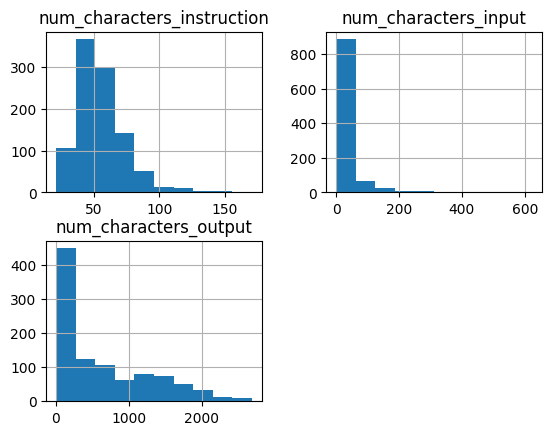

In [8]:
# Calculating the length of each cell in each column
df['num_characters_instruction'] = df['instruction'].apply(lambda x: len(x))
df['num_characters_input'] = df['input'].apply(lambda x: len(x))
df['num_characters_output'] = df['output'].apply(lambda x: len(x))

# Show Distribution
df.hist(column=['num_characters_instruction', 'num_characters_input', 'num_characters_output'])

# Calculating the average
average_chars_instruction = df['num_characters_instruction'].mean()
average_chars_input = df['num_characters_input'].mean()
average_chars_output = df['num_characters_output'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

In [9]:
"""
Uncomment the below to experiment with zero-shot prompting of the model.

Note that you may need to restart the notebook and comment out this section again
if you wish to perform the fine-tuning below, as running the zero-shot prompting
will allocate some additional memory on the GPU that can lead to CUDA OOM issues.
"""

# zero_shot_config = yaml.safe_load(
#   """
#   model_type: llm
#   base_model: meta-llama/Llama-2-7b-hf

#   input_features:
#     - name: instruction
#       type: text

#   output_features:
#     - name: output
#       type: text

#   prompt:
#     template: >-
#       Below is an instruction that describes a task, paired with an input
#       that may provide further context. Write a response that appropriately
#       completes the request.

#       ### Instruction: {instruction}

#       ### Input: {input}

#       ### Response:

#   generation:
#     temperature: 0.1 # Temperature is used to control the randomness of predictions.
#     max_new_tokens: 512

#   preprocessing:
#     split:
#       type: fixed

#   quantization:
#     bits: 4
#   """
# )

# model = LudwigModel(config=zero_shot_config, logging_level=logging.INFO)
# results = model.train(dataset=df[:10])

'\nUncomment the below to experiment with zero-shot prompting of the model.\n\nNote that you may need to restart the notebook and comment out this section again\nif you wish to perform the fine-tuning below, as running the zero-shot prompting\nwill allocate some additional memory on the GPU that can lead to CUDA OOM issues.\n'

In [10]:
qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: meta-llama/Llama-2-7b-hf

input_features:
  - name: instruction
    type: text

output_features:
  - name: output
    type: text

prompt:
  template: >-
    Below is an instruction that describes a task, paired with an input
    that provides further context. Write a response that appropriately
    completes the request.

    ### Instruction: {instruction}

    ### Input: {input}

    ### Response:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 1
    - 0
    - 0

trainer:
  type: finetune
  epochs: 1
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.0004
  learning_rate_scheduler:
    warmup_fraction: 0.03
"""
)

model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'None': 184 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 186 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 186 for feature 'None'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'output': 742 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 744 (including start and stop symbols)
INFO:ludwig.featur

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 1000 step(s), approximately 1 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 5000 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training: 100%|██████████| 1000/1000 [13:43<00:00,  1.42it/s, loss=0.0107]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 1000, epoch: 0
INFO:ludwig.trainers.trainer:Evaluation took 0.2326s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════╕
│                       │      train │ validation   │ test   │
╞═══════════════════════╪════════════╪══════════════╪════════╡
│ bleu                  │     0.2275 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ char_error_rate       │     0.6830 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ loss                  │     1.4652 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ next_token_perplexity │ 17645.8496 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ perplexity            │ 31704.5605 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ rouge1_fmea

Training: 100%|██████████| 1000/1000 [13:44<00:00,  1.21it/s, loss=0.0107]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ FINISHED │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


#### Perform Inference

We can now use the model we fine-tuned above to make predictions on some test examples to see whether fine-tuning the large language model improve its ability to follow instructions/the tasks we're asking it to perform.

In [15]:
test_examples = pd.DataFrame([
      {
            "instruction": "Explain what carbon footprint is in one sentence.",
            "input": ''
      },
      {
            "instruction": "What is the meaning of Life.",
            "input": "",
      },
      {
            "instruction": "Create a to-do list for a morning routine for a Stanford student.",
            "input": ""
      },
      {
            "instruction": "Describe two benefits of going to college like Stanford",
            "input": "",
      },
      {
            "instruction": "Create a method to solve a 2x2 system of equations.",
            "input": "",
      },
      {
            "instruction": "Identify the historical figure mentioned in the article below.",
            "input": "The famous physicist Albert Einstein was one of the most influential scientists of the 20th century.",
      },
])

predictions = model.predict(test_examples)[0]
for input_with_prediction in zip(test_examples['instruction'], test_examples['input'], predictions['output_response']):
  print(f"Instruction: {input_with_prediction[0]}")
  print(f"Input: {input_with_prediction[1]}")
  print(f"Generated Output: {input_with_prediction[2][0]}")
  print("\n\n")

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriately completes the request.
### instruction: explain what carbon footprint is in one sentence.
### input: 
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriately completes the request.
### instruction: explain what carbon footprint is in one sentence.
### input: 
### response: a carbon footprint is the amount of greenhouse gases emitted by an individual, organization, or country over a specific period of time.
INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriate

Prediction: 100%|██████████| 1/1 [00:59<00:00, 59.39s/it]


INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer


Instruction: Explain what carbon footprint is in one sentence.
Input: 
Generated Output: a carbon footprint is the amount of greenhouse gases emitted by an individual, organization, or country over a specific period of time.



Instruction: What is the meaning of Life.
Input: 
Generated Output: the meaning of life is different for everyone. it is a personal and subjective concept that can be interpreted in many ways. some people may find the meaning of life in their relationships, while others may find it in their work or in their spirituality. ultimately, the meaning of life is what each individual defines it to be.



Instruction: Create a to-do list for a morning routine for a Stanford student.
Input: 
Generated Output: a morning routine for a stanford student:

1. wake up at 6:00 am
2. drink a glass of water
3. meditate for 10 minutes
4. stretch for 10 minutes
5. eat a healthy breakfast
6. read the news
7. plan out the day
8. exercise for 30 minutes
9. shower
10. get ready for the 

/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriately completes the request.
### instruction: explain what carbon footprint is in one sentence.
### input: 
### response:
INFO:ludwig.models.llm:Decoded generated output for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriately completes the request.
### instruction: explain what carbon footprint is in one sentence.
### input: 
### response: a carbon footprint is the amount of greenhouse gases emitted by an individual, organization, or country over a specific period of time.
INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriate

Prediction: 100%|██████████| 1/1 [01:28<00:00, 88.19s/it]


INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of meta-llama/Llama-2-7b-hf tokenizer


Instruction: Explain what carbon footprint is in one sentence.
Input: 
Generated Output: a carbon footprint is the amount of greenhouse gases emitted by an individual, organization, or country over a specific period of time.



Instruction: What is the meaning of Life.
Input: 
Generated Output: the meaning of life is different for everyone. it is a personal journey that involves exploring one's own values, beliefs, and purpose. some people may find meaning in their relationships, while others may find it in their work or creative pursuits. ultimately, the meaning of life is what each individual defines for themselves.



Instruction: Create a to-do list for a morning routine for a Stanford student.
Input: 
Generated Output: the morning routine for a stanford student should include the following tasks:

1. wake up at 6:00 am
2. drink a glass of water
3. meditate for 10 minutes
4. stretch for 10 minutes
5. eat a healthy breakfast
6. read the news
7. check emails and social media
8. plan 

/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


# **Upload Trained Model Artifacts To HuggingFace** 🤗

Now that we have a fine-tuned model, we can export the model weights to HuggingFace hub so we can use them in downstream tasks or in production. Ludwig supports uploading model weights directly to HuggingFace Hub via the `upload` Ludwig command.

```
!ludwig upload hf_hub --repo_id <hf_user_name>/<repo_name> --model_path <top_level_model_directory>
```

The `model-path` can be seen at the end of training/fine-tuning, as seen in this screenshot.

<br>

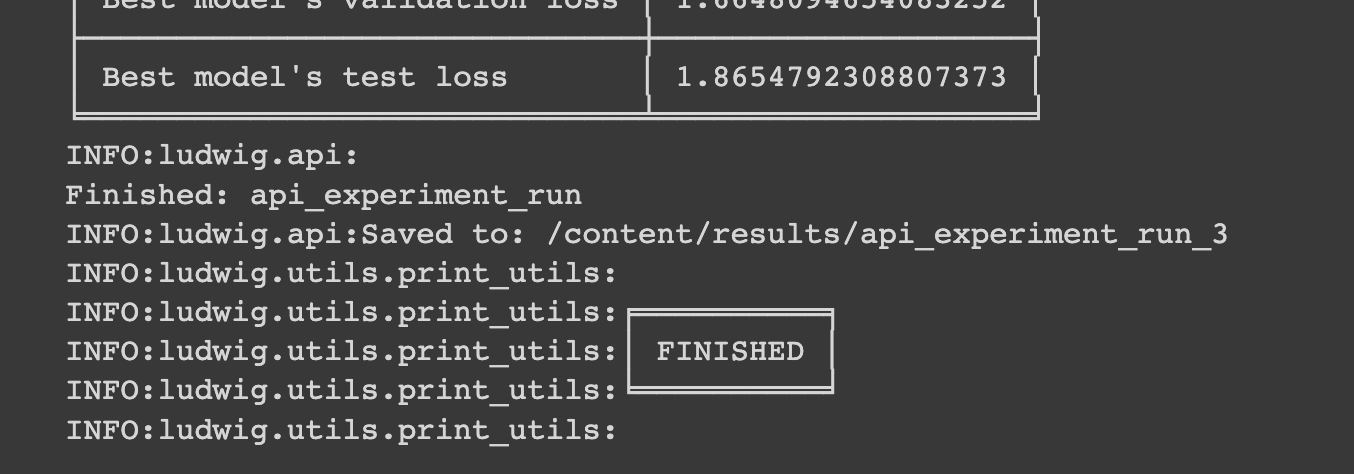

In [16]:
from huggingface_hub import notebook_login

notebook_login()

In [17]:
!ludwig upload hf_hub --repo_id Puch/alpaca_GPT-4_llama7b --model_path /content/results/api_experiment_run

adapter_model.bin: 100% 16.8M/16.8M [00:04<00:00, 3.77MB/s]
Model uploaded to `https://huggingface.co/Puch/alpaca_GPT-4_llama7b/tree/main/` with repository name `Puch/alpaca_GPT-4_llama7b`


#### Want to try out our QLoRA fine-tuned weights that were fine-tuned on the entire dataset over 3 epochs? Check it out here on HuggingFace 🤗: https://huggingface.co/arnavgrg/codealpaca-qlora

```
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM

config = PeftConfig.from_pretrained("arnavgrg/codealpaca-qlora")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf")
model = PeftModel.from_pretrained(model, "arnavgrg/codealpaca-qlora")
```